In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
%pip install git+https://github.com/boudinfl/pke.git
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-2bteirc2
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-2bteirc2
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.2 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160676 sha256=9e59491fea64ceb067bbb42d72614ee4f23858b62985e041a728dc688344f36b
  Stored in directory: /tmp/pip-ephem-wheel-cache-oga9il8t/wheels/d5/46/97/85535b5b449f70b6a3c8d1138ce8587345876891e25bfe7954
Successfully built pke
2023-04-17 20:08:41.097246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To 

In [4]:
import pke
import string
import re

stoplist = list(string.punctuation)
stoplist += pke.lang.stopwords.get('en')

def multi_partite_rank_extract(text, n):
    text = re.sub(r'<.*?>', '', text)
    multi_partite_rank = pke.unsupervised.MultipartiteRank()
    multi_partite_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    multi_partite_rank.candidate_selection(pos=pos)
    multi_partite_rank.candidate_weighting()
    return multi_partite_rank.get_n_best(n=n)

In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
img_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-imageability').to(device)


In [9]:
def predict(token,model):
    inputs = tokenizer(token, return_tensors='pt').to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.item()

In [10]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def any_in(keyphrase, input_words):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 

In [11]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']

In [12]:
def map_keywords_and_scores(example):
    for key in keys:
        keywords = multi_partite_rank_extract(example[key], n=10)
        example[key + '_keywords'] = [keyword for keyword, weight in keywords]
        example[key + '_keyword_scores'] = [weight for keyword, weight in keywords]

    return example

In [20]:
ds_keywords = ds.map(map_keywords_and_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [62]:
import numpy as np

def imageability_score(keywords_with_scores):
    scores = [] 
    total_weight = 0
    for keyphrase, weight in keywords_with_scores:
        total_weight += weight
    
    for keyphrase, weight in keywords_with_scores:
        words = keyphrase.split(' ')
        score = np.mean([predict(word,img_model) for word in words])
        scores.append(score * weight / total_weight)
    
    return np.sum(scores)

In [63]:
def centrality_score(keywords_with_scores, input_words):
    total_score = 0
    for _, score in keywords_with_scores:
        total_score += score
    
    mask = [(any_in(keyphrase, input_words), score / total_score) for keyphrase, score in keywords_with_scores]

    return np.sum([score for in_input, score in mask if in_input])

In [221]:
def combined_score(keywords_with_scores, input_words):
    centrality = centrality_score(keywords_with_scores[:len(input_words)], input_words)
    imageability = imageability_score(keywords_with_scores[:len(input_words)])
    return (centrality, imageability)

In [177]:
sample = ds_keywords['train'][0]
sample_input_words = [sample['kanji_meaning']] + sample['component_meanings'].split(',')
key = keys[1]
keywords_with_scores = list(zip(sample[key + '_keywords'], sample[key + '_keyword_scores']))

In [198]:
def map_combined_score(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        centrality, img = combined_score(keywords_with_scores, input_words)
        example[key+'_img'] = img
        example[key+'_centrality'] = centrality
    return example

In [222]:
map_combined_score(sample)['wanikani_mnemonic_centrality']

0.7801173458037225

In [223]:
ds_scores = ds_keywords['train'].map(map_combined_score)

In [201]:
from scipy.stats import f_oneway
def anova(ds, feature):
    f, p = f_oneway(*[ds[key+'_'+feature] for key in keys])
    return f, p

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds,title, feature, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_'+feature] for key in keys], labels=labels)
    plt.show()

In [25]:
from scipy.stats import tukey_hsd

def tukey(ds, feature):
    data = [ds[key+'_'+feature] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [26]:
def mean_std(ds, feature):
    return [(key, np.mean(ds[key+'_'+feature]), np.std(ds[key+'_'+feature])) for key in keys]

In [112]:
def map_weighted(centrality_weight=.5):
    def inner(example):
        for key in keys:
            example[key+'_weighted_score'] = example[key+'_centrality'] * centrality_weight + example[key+'_img'] * (1-centrality_weight)
        return example
    return inner

In [224]:
centrality_weights = np.linspace(0,1,11)
p_values = []
ds_combineds = []

for centrality_weight in centrality_weights:
    ds_combined = ds_scores.map(map_weighted(centrality_weight))
    ds_combineds.append(ds_combined)
    _, p = anova(ds_combined, 'weighted_score')
    p_values.append(p)

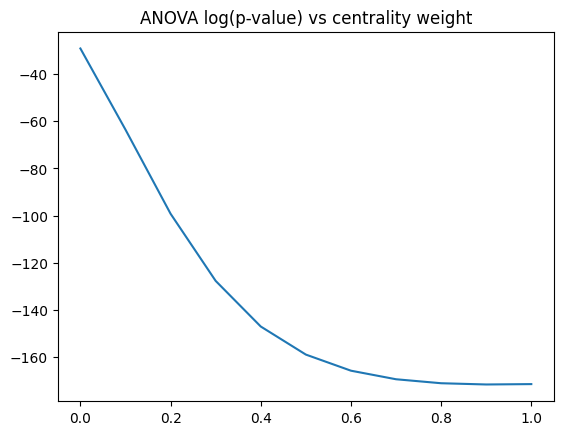

In [225]:
plt.title('ANOVA log(p-value) vs centrality weight')
plt.plot(centrality_weights, np.log(p_values))
plt.show()

In [226]:
centrality_weights[p_values.index(min(p_values))]

0.9

In [227]:
ds_final = ds_scores.map(map_weighted(.6))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [228]:
mean_std(ds_final, 'weighted_score')

[('gpt2xl_mnemonic', 0.3532793584631118, 0.15644408896593023),
 ('gpt3_mnemonic', 0.5990238700568759, 0.17514579153292936),
 ('gpt3_paragraph', 0.4880463600229131, 0.17300774745237815),
 ('wanikani_mnemonic', 0.6940474828487156, 0.17323912313417492)]

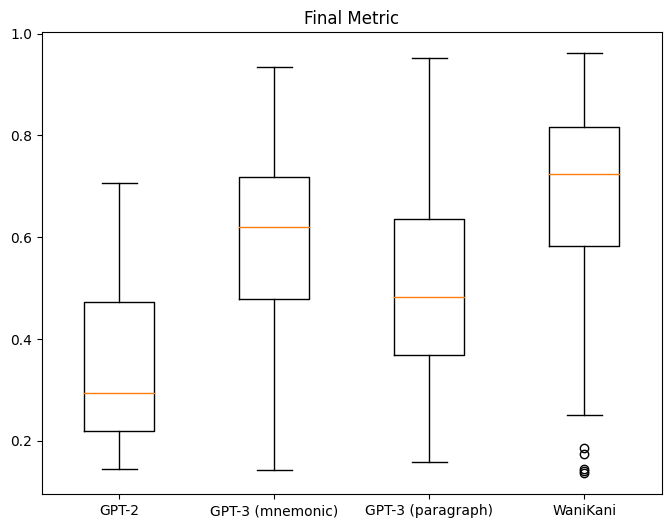

In [229]:
box_plot(ds_final, 'Final Metric', 'weighted_score')

In [230]:
print(anova(ds_final, 'weighted_score'))

(141.473717426137, 9.371034058828216e-73)


In [231]:
tukey(ds_final, 'weighted_score')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.246     0.000    -0.291    -0.201
 (0 - 2)     -0.135     0.000    -0.180    -0.090
 (0 - 3)     -0.341     0.000    -0.386    -0.296
 (1 - 0)      0.246     0.000     0.201     0.291
 (1 - 2)      0.111     0.000     0.066     0.156
 (1 - 3)     -0.095     0.000    -0.140    -0.050
 (2 - 0)      0.135     0.000     0.090     0.180
 (2 - 1)     -0.111     0.000    -0.156    -0.066
 (2 - 3)     -0.206     0.000    -0.251    -0.161
 (3 - 0)      0.341     0.000     0.296     0.386
 (3 - 1)      0.095     0.000     0.050     0.140
 (3 - 2)      0.206     0.000     0.161     0.251



In [232]:
def print_mnemonic(key):
    def inner(x):
        print(x['kanji_meaning'], x['component_meanings'])
        print(x[key])
        print()
    return inner

In [233]:

ds_final.to_pandas().sort_values('wanikani_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('wanikani_mnemonic'), axis=1)

house roof,pig
Under this <radical>roof</radical> is a <radical>pig</radical>. Your pig, because it's your <kanji>house</kanji>! You keep your pig inside where it's nice and warm. He's a member of your family, so he deserves to live in your <kanji>home</kanji> too. Picture the little pig, prancing around happily under the roof of your house.

road foot,kiss
If you’ve been walking all day, nobody is going to want to <radical>kiss</radical> your <radical>foot</radical> if you’ve been walking barefoot down a dirt <kanji>road</kanji>. Your feet are filthy, sweaty, and stinky. Nobody is going to want to kiss those feet. Imagine kissing someone’s foot. Now imagine kissing someone’s foot after they’ve been walking down a dirt road for hours. It’s disgusting. Smell the stench of dirt and sweat wafting up into your nostrils as the foot approaches your lips. It’s wretched.



66    None
32    None
dtype: object

In [235]:
ds_final.to_pandas().sort_values('wanikani_mnemonic_weighted_score', ascending=True).iloc[4:6].apply(print_mnemonic('wanikani_mnemonic'), axis=1)

both ground,head,mountain
Under the <radical>ground</radical>, which you dug into, you found two great finds. You found <kanji>both</kanji> a <radical>mountain</radical> and a <radical>head</radical>, two strange things to find underground. You'll want to focus on the part where you find <kanji>both</kanji>, not so much the things themselves. Think about how you can't believe you did so well finding both things at once. Usually you only find one or the other when you're searching.

sunlight triceratops,pi
You see a <radical>triceratops</radical> in the distance. But, it's odd. It's perfectly <radical>pi</radical> shaped (that is, circular). Some kind of piceratops, if you will. The reason they are this shape is because they want to absorb as much <kanji>sunlight</kanji> (or just <kanji>light</kanji> is fine, too) as possible. They evolved to be round so they don't have any corners casting a shadow. Absorbing sunlight is natural for reptiles, after all. And a round one can absorb even m

147    None
122    None
dtype: object

In [236]:
ds_final.to_pandas().sort_values('gpt2xl_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt2xl_mnemonic'), axis=1)

throw up mouth,dirt
I throw up a little mouthful of dirt when I think about it. It's the first thing that comes to my mind, even though there are so many more important things going on in this world than whether or not we've got enough money for our kids' college educations (which is an entirely separate issue). But if you ask me

planting plow,drunkard
This is a plow drunkard's guide to planting trees in your yard. If you don't know what I'm talking about, check out my previous post on the subject: How To Plant A Tree In Your Backyard (And Why You Should Do It). This time we'll be looking at different types of tree species and how they can



53    None
45    None
dtype: object

In [237]:
ds_final.to_pandas().sort_values('gpt3_mnemonic_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt3_mnemonic'), axis=1)

willow tree,stamp
Once upon a time, there was a willow tree in a meadow. One day, a curious stamp collector was walking by and noticed the tree. He stopped to admire the tree and marveled at its beauty. He decided to take a stamp from his collection and place it on the tree as a reminder of the moment. The willow tree will forever serve as a reminder of the stamp collector's admiration.

boisterous mouth,mask
Once upon a time, there was a boisterous young man who always wore a mask over his mouth. He was always so loud and energetic, and he was always getting himself into trouble. One day, he got so boisterous that his mask flew off and people were shocked at what was underneath. He had a big mouth full of sharp teeth and everyone ran away in fear! From then on, he was careful to keep his mouth covered with his mask, so as not to scare anyone again.



67    None
69    None
dtype: object

In [217]:
ds_final.to_pandas().sort_values('gpt3_mnemonic_weighted_score', ascending=True).iloc[:2].apply(print_mnemonic('gpt3_mnemonic'), axis=1)

trust bundle,geoduck
Once upon a time there was a geoduck who wanted to start a business. He was determined to succeed, so he bundled all of his resources together and trusted that his hard work would pay off. He was eventually able to open a successful shop and became a well-respected member of the community.

admonish say,death star
Once upon a time, there was a young man who wanted to explore the universe. He decided to take a journey to the Death Star, but his parents admonished him and said, "Say no to this dangerous mission!" Despite their warnings, the young man was determined to explore the depths of space, so he said goodbye and set off on his adventure.



12    None
62    None
dtype: object

In [219]:
ds_final.to_pandas().sort_values('gpt3_paragraph_weighted_score', ascending=False).iloc[:2].apply(print_mnemonic('gpt3_paragraph'), axis=1)

carp fish,village
The small village was famous for its abundance of fish, particularly carp. Every morning, the villagers would go out to the lake and catch carp for their breakfast. It was a tradition that had been passed down from generation to generation, and the villagers were proud of their fishing heritage.

boulder mountain,stone
The mountain was covered in stones and boulders of all shapes and sizes. Some of the boulders were so large that they seemed to be a part of the mountain itself. It was a beautiful sight to behold, and it made the mountain look even more majestic.



174    None
115    None
dtype: object

In [220]:
ds_final.to_pandas().sort_values('gpt3_paragraph_weighted_score', ascending=True).iloc[:2].apply(print_mnemonic('gpt3_paragraph'), axis=1)

past dirt,private
The dirt of my private past is something I don't like to think about. I try to keep it buried and out of sight, but sometimes it is hard to forget.

alert every,winter
Every winter, I'm on alert for the first snowfall of the season. I love the way it blankets the ground in a peaceful white and being able to experience the beauty of nature's transformation.



47    None
89    None
dtype: object